In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.applications import MobileNetV2, ResNet50
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mobilenet_preprocess
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess

from sklearn.metrics import classification_report, confusion_matrix


In [4]:
DATASET_PATH = "/content/drive/MyDrive/Dataset uap"

TRAIN_DIR = os.path.join(DATASET_PATH, "train")
VAL_DIR   = os.path.join(DATASET_PATH, "validation")
TEST_DIR  = os.path.join(DATASET_PATH, "test")

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 10
NUM_CLASSES = 5
CLASS_NAMES = ['bus', 'car', 'motorcycle', 'train_vehicle', 'truck']


Data generator

In [5]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_gen = val_test_datagen.flow_from_directory(
    VAL_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_gen = val_test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)


Found 5428 images belonging to 5 classes.
Found 709 images belonging to 5 classes.
Found 708 images belonging to 5 classes.


**MODEL 1 : non-pretrained**

CNN Base

In [6]:
cnn_base = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(224,224,3)),
    MaxPooling2D(),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(NUM_CLASSES, activation='softmax')
])

cnn_base.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

cnn_base.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,605 (42.61 MB)

 Trainable params: 11,169,605 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

Training CNN

In [7]:
history_cnn = cnn_base.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
170/170 ━━━━━━━━━━━━━━━━━━━━ 1863s 11s/step - accuracy: 0.3032 - loss: 1.5932 - val_accuracy: 0.4570 - val_loss: 1.3223
Epoch 2/10
170/170 ━━━━━━━━━━━━━━━━━━━━ 87s 512ms/step - accuracy: 0.4820 - loss: 1.2975 - val_accuracy: 0.5642 - val_loss: 1.0934
Epoch 3/10
170/170 ━━━━━━━━━━━━━━━━━━━━ 88s 520ms/step - accuracy: 0.5354 - loss: 1.1971 - val_accuracy: 0.6037 - val_loss: 1.0154
Epoch 4/10
170/170 ━━━━━━━━━━━━━━━━━━━━ 89s 523ms/step - accuracy: 0.5612 - loss: 1.1309 - val_accuracy: 0.6389 - val_loss: 0.9724
Epoch 5/10
170/170 ━━━━━━━━━━━━━━━━━━━━ 88s 516ms/step - accuracy: 0.5934 - loss: 1.0714 - val_accuracy: 0.6544 - val_loss: 0.9079
Epoch 6/10
170/170 ━━━━━━━━━━━━━━━━━━━━ 89s 525ms/step - accuracy: 0.6136 - loss: 1.0173 - val_accuracy: 0.6347 - val_loss: 0.9475
Epoch 7/10
170/170 ━━━━━━━━━━━━━━━━━━━━ 89s 521ms/step - accuracy: 0.6216 - loss: 0.9916 - val_accuracy: 0.6841 - val_loss: 0.8403
Epoch 8/10
170/170 ━━━━━━━━━━━━━━━━━━━━ 88s 516ms/step - accuracy: 0.6473 - loss: 0

**MODEL 2 : PRETRAINED**

MobileNetV2

In [8]:
base_mobilenet = MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(224,224,3)
)

base_mobilenet.trainable = False

mobilenet_model = Sequential([
    base_mobilenet,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(NUM_CLASSES, activation='softmax')
])

mobilenet_model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

mobilenet_model.summary()


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,597 (9.24 MB)

 Trainable params: 164,613 (643.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Training MobileNetV2

In [9]:
history_mobilenet = mobilenet_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS
)

Epoch 1/10
170/170 ━━━━━━━━━━━━━━━━━━━━ 129s 656ms/step - accuracy: 0.4783 - loss: 1.3544 - val_accuracy: 0.8590 - val_loss: 0.4583
Epoch 2/10
170/170 ━━━━━━━━━━━━━━━━━━━━ 86s 507ms/step - accuracy: 0.7693 - loss: 0.6486 - val_accuracy: 0.8801 - val_loss: 0.3518
Epoch 3/10
170/170 ━━━━━━━━━━━━━━━━━━━━ 86s 506ms/step - accuracy: 0.8036 - loss: 0.5507 - val_accuracy: 0.8815 - val_loss: 0.3150
Epoch 4/10
170/170 ━━━━━━━━━━━━━━━━━━━━ 87s 512ms/step - accuracy: 0.8124 - loss: 0.5209 - val_accuracy: 0.8900 - val_loss: 0.3029
Epoch 5/10
170/170 ━━━━━━━━━━━━━━━━━━━━ 86s 506ms/step - accuracy: 0.8406 - loss: 0.4384 - val_accuracy: 0.8914 - val_loss: 0.3001
Epoch 6/10
170/170 ━━━━━━━━━━━━━━━━━━━━ 87s 510ms/step - accuracy: 0.8334 - loss: 0.4499 - val_accuracy: 0.8942 - val_loss: 0.2770
Epoch 7/10
170/170 ━━━━━━━━━━━━━━━━━━━━ 86s 504ms/step - accuracy: 0.8361 - loss: 0.4423 - val_accuracy: 0.8886 - val_loss: 0.2781
Epoch 8/10
170/170 ━━━━━━━━━━━━━━━━━━━━ 87s 513ms/step - accuracy: 0.8604 - loss: 

**MODEL 3 : PRETRAINED**

ResNet50

In [10]:
base_resnet = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(224,224,3)
)

base_resnet.trainable = False

resnet_model = Sequential([
    base_resnet,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(NUM_CLASSES, activation='softmax')
])

resnet_model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

resnet_model.summary()


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,850,629 (90.98 MB)

 Trainable params: 262,917 (1.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

Training ResNet50

In [11]:
history_resnet = resnet_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS
)


Epoch 1/10
170/170 ━━━━━━━━━━━━━━━━━━━━ 115s 601ms/step - accuracy: 0.2463 - loss: 1.7677 - val_accuracy: 0.4090 - val_loss: 1.4808
Epoch 2/10
170/170 ━━━━━━━━━━━━━━━━━━━━ 90s 530ms/step - accuracy: 0.3437 - loss: 1.5254 - val_accuracy: 0.3963 - val_loss: 1.4394
Epoch 3/10
170/170 ━━━━━━━━━━━━━━━━━━━━ 90s 526ms/step - accuracy: 0.3545 - loss: 1.4835 - val_accuracy: 0.4471 - val_loss: 1.4011
Epoch 4/10
170/170 ━━━━━━━━━━━━━━━━━━━━ 91s 533ms/step - accuracy: 0.3716 - loss: 1.4687 - val_accuracy: 0.4245 - val_loss: 1.3952
Epoch 5/10
170/170 ━━━━━━━━━━━━━━━━━━━━ 90s 529ms/step - accuracy: 0.3651 - loss: 1.4555 - val_accuracy: 0.4457 - val_loss: 1.3696
Epoch 6/10
170/170 ━━━━━━━━━━━━━━━━━━━━ 90s 529ms/step - accuracy: 0.3817 - loss: 1.4457 - val_accuracy: 0.4683 - val_loss: 1.3665
Epoch 7/10
170/170 ━━━━━━━━━━━━━━━━━━━━ 89s 525ms/step - accuracy: 0.3819 - loss: 1.4334 - val_accuracy: 0.4598 - val_loss: 1.3504
Epoch 8/10
170/170 ━━━━━━━━━━━━━━━━━━━━ 91s 533ms/step - accuracy: 0.4101 - loss: 

**EVALUASI MODEL**

Classification Report

In [12]:
def evaluate_model(model, name):
    y_true = test_gen.classes
    y_pred = np.argmax(model.predict(test_gen), axis=1)

    print(f"\n=== Classification Report: {name} ===")
    print(classification_report(y_true, y_pred, target_names=CLASS_NAMES))

evaluate_model(cnn_base, "CNN Base")
evaluate_model(mobilenet_model, "MobileNetV2")
evaluate_model(resnet_model, "ResNet50")


23/23 ━━━━━━━━━━━━━━━━━━━━ 248s 11s/step

=== Classification Report: CNN Base ===
               precision    recall  f1-score   support

          bus       0.77      0.82      0.80       180
          car       0.74      0.55      0.63       107
   motorcycle       0.82      0.84      0.83       139
train_vehicle       0.67      0.81      0.73       182
        truck       0.58      0.43      0.49       100

     accuracy                           0.73       708
    macro avg       0.72      0.69      0.70       708
 weighted avg       0.72      0.73      0.72       708

23/23 ━━━━━━━━━━━━━━━━━━━━ 18s 641ms/step

=== Classification Report: MobileNetV2 ===
               precision    recall  f1-score   support

          bus       0.92      0.91      0.92       180
          car       0.84      0.79      0.81       107
   motorcycle       0.98      0.99      0.99       139
train_vehicle       0.95      0.90      0.92       182
        truck       0.73      0.85      0.79       100

  

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Grafik Loss & Accuracy

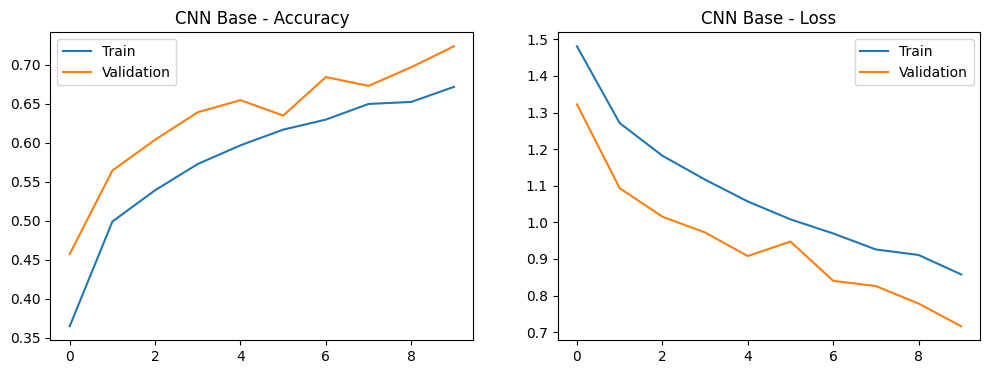

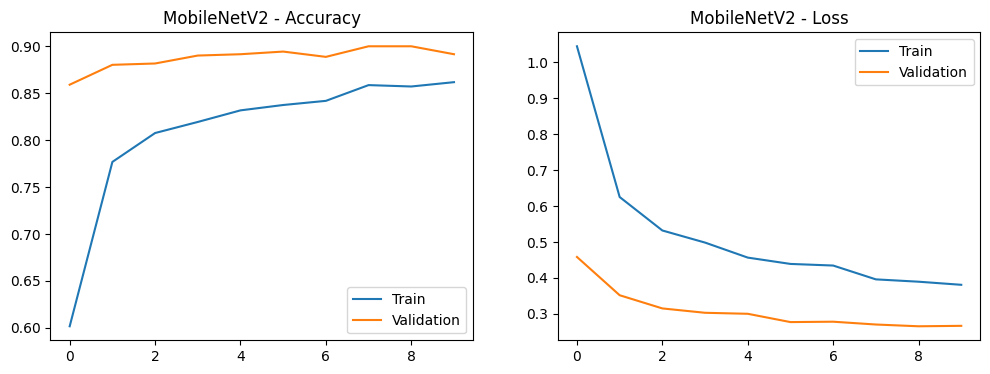

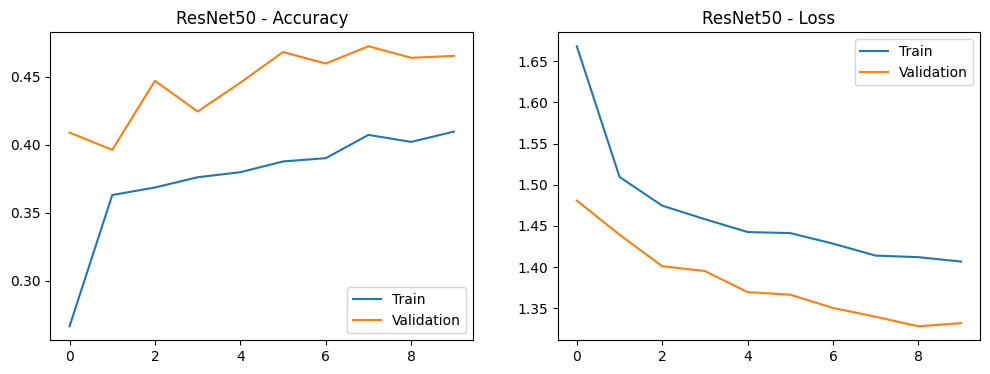

In [13]:
def plot_history(history, title):
    plt.figure(figsize=(12,4))

    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(f'{title} - Accuracy')
    plt.legend(['Train', 'Validation'])

    plt.subplot(1,2,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(f'{title} - Loss')
    plt.legend(['Train', 'Validation'])

    plt.show()

plot_history(history_cnn, "CNN Base")
plot_history(history_mobilenet, "MobileNetV2")
plot_history(history_resnet, "ResNet50")


Confusion Matrix

23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 153ms/step


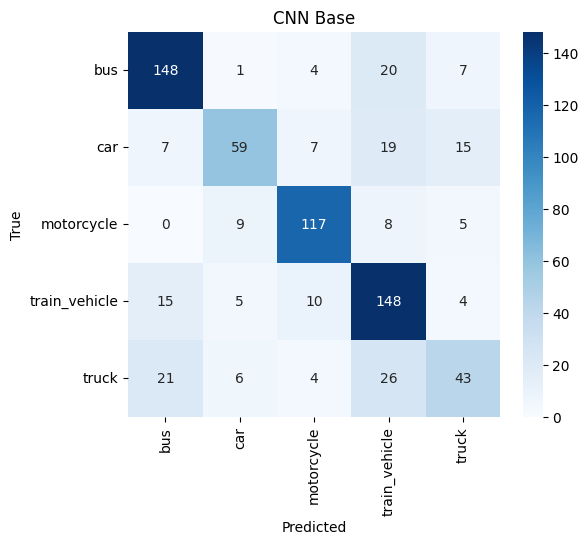

23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 178ms/step


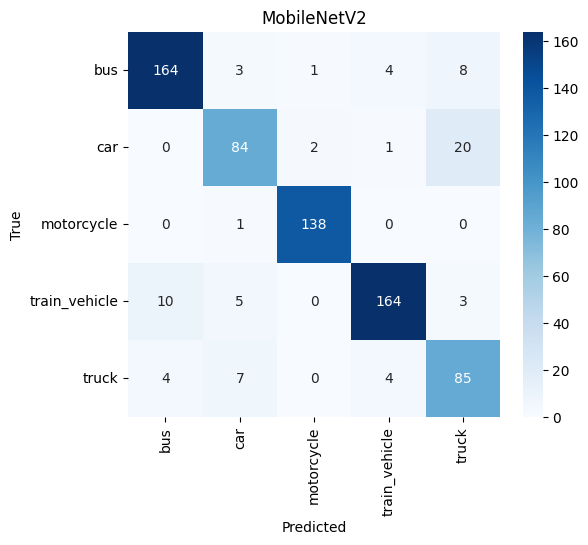

23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 154ms/step


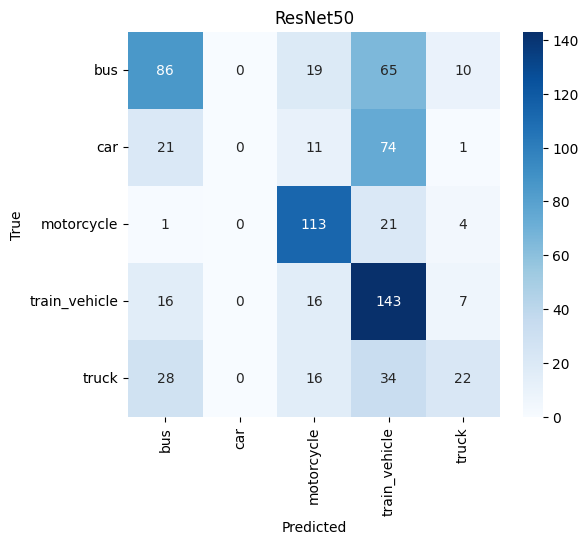

In [14]:
def plot_confusion(model, title):
    y_true = test_gen.classes
    y_pred = np.argmax(model.predict(test_gen), axis=1)
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d',
                xticklabels=CLASS_NAMES,
                yticklabels=CLASS_NAMES,
                cmap='Blues')
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

plot_confusion(cnn_base, "CNN Base")
plot_confusion(mobilenet_model, "MobileNetV2")
plot_confusion(resnet_model, "ResNet50")


**Fungsi test model**

In [15]:
from tensorflow.keras.preprocessing import image

def load_and_preprocess_image(img_path, img_size=(224,224)):
    img = image.load_img(img_path, target_size=img_size)
    img_array = image.img_to_array(img)
    img_array = img_array / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    return img, img_array


In [16]:
def predict_top5_from_class(
    model,
    dataset_dir,
    target_class,
    class_names,
    num_images=5
):
    class_dir = os.path.join(dataset_dir, target_class)
    img_files = sorted(os.listdir(class_dir))[:num_images]

    plt.figure(figsize=(10, 3))

    for i, img_name in enumerate(img_files):
        img_path = os.path.join(class_dir, img_name)

        # Load image
        img, img_array = load_and_preprocess_image(img_path)

        # Predict
        preds = model.predict(img_array)[0]

        # Ambil TOP-5
        top5_idx = np.argsort(preds)[::-1][:5]
        top5_labels = [class_names[j] for j in top5_idx]
        top5_scores = [preds[j]*100 for j in top5_idx]

        # Plot
        plt.subplot(1, num_images, i+1)
        plt.imshow(img)
        plt.axis('off')

        title = ""
        for lbl, score in zip(top5_labels, top5_scores):
            title += f"{lbl}: {score:.1f}%\n"

        plt.title(title, fontsize=10)

    plt.show()


Test CNN Base

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 711ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


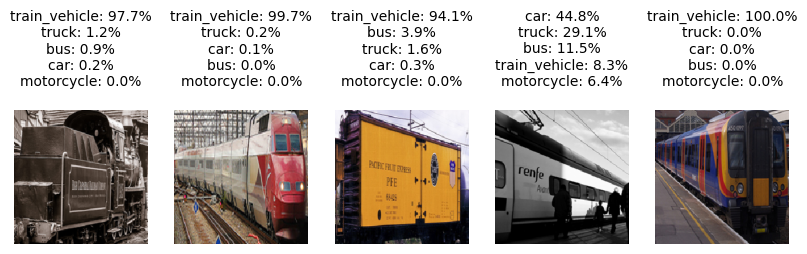

In [17]:
predict_top5_from_class(
    model=cnn_base,
    dataset_dir=TEST_DIR,
    target_class="train_vehicle",
    class_names=CLASS_NAMES,
    num_images=5
)


Test MobileNetV2

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


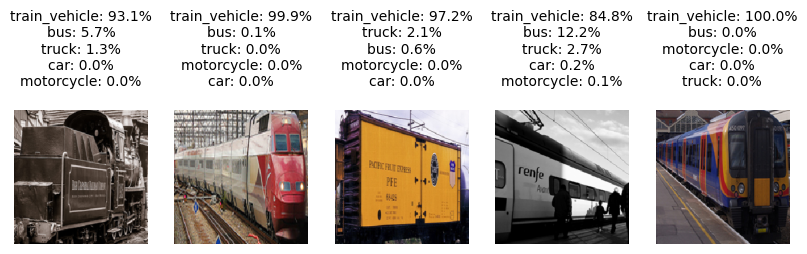

In [18]:
predict_top5_from_class(
    model=mobilenet_model,
    dataset_dir=TEST_DIR,
    target_class="train_vehicle",
    class_names=CLASS_NAMES,
    num_images=5
)


Test ResNet50

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


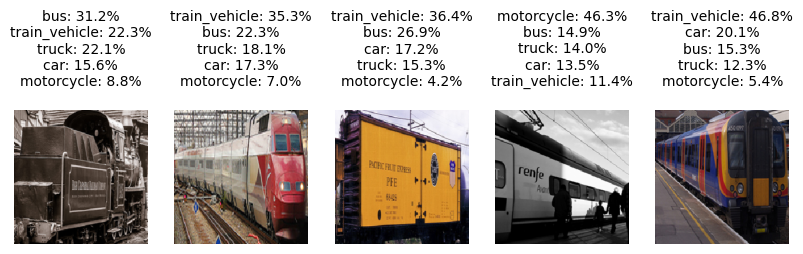

In [19]:
predict_top5_from_class(
    model=resnet_model,
    dataset_dir=TEST_DIR,
    target_class="train_vehicle",
    class_names=CLASS_NAMES,
    num_images=5
)


**simpan model**

In [25]:
SAVE_DIR = "/content/drive/MyDrive/model_uaprev"
os.makedirs(SAVE_DIR, exist_ok=True)

# Nama file WAJIB diakhiri dengan .weights.h5
cnn_base.save_weights(os.path.join(SAVE_DIR, "cnn_weights.weights.h5"))
mobilenet_model.save_weights(os.path.join(SAVE_DIR, "mobilenet_weights.weights.h5"))
resnet_model.save_weights(os.path.join(SAVE_DIR, "resnet_weights.weights.h5"))

print("✅ Semua bobot model berhasil disimpan!")

✅ Semua bobot model berhasil disimpan!


In [21]:
import tensorflow as tf
print(tf.__version__)

2.19.0
